# Load Libraries

In [1]:
# Standard libraries
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated') # Known issue with PyTorch and DGL
import IPython

# Data handling
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN

# Neural Networks and Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import optuna

# Graph Neural Networks
import dgl
import dgl.nn as dglnn
from dgl import batch
from dgl.data.utils import save_graphs, load_graphs
from dgl.nn import GATConv

# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from dgllife.utils import mol_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_graph
from chembl_structure_pipeline import standardizer

# Network analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns




I have these five datasets: robin.sdf, life_chemicals.sdf, enamine_rna.sdf, enamine_protein.sdf, chemdiv.sdf, and I will provide you with the code which jou have to optimize, make more functional and taylor to the objective. First of all you will use mainly RDkit and standardizer from chembl structure pipeline. The robin sdf have 3D molecules so we need to change that to 2D molecules. The next step is standardize the molecules using standardizer and also discard of the fragments (possible salts), next  will be deduplicate the datasets - for this part is useful to use SMILES representation. Lastly the process will be check and verified that molecules are deduplicated, sanitized and to not contain salts. It is essential to keep the source of the molecules also provide logs from each step. Keed the code clean as possible. Provide whole modified code to the provided sdf file names

robin.sdf, life_chemicals.sdf, enamine_rna.sdf, enamine_protein.sdf, chemdiv.sdf

check if GPU is aviable and the device

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA Supported?", torch.cuda.is_available())

PyTorch version: 2.1.2
Is CUDA Supported? True


In [3]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla T4')

# Data Preprocessing

load dataset

In [4]:
# enmine_protein = pd.read_json('data_mvi/enamine_protein_df.json')


In [5]:
# load json data from data_mvi folder
chemdiv = pd.read_json('data_mvi/chemdiv_df.json')
enamine = pd.read_json('data_mvi/enamine_df.json')
enmine_protein = pd.read_json('data_mvi/picked_molecules.json')
life_chemicals = pd.read_json('data_mvi/life_chemicals_df.json')
robin = pd.read_json('data_mvi/robin_df.json')

FileNotFoundError: File data_mvi/chemdiv_df.json does not exist

In [ ]:
datasets = [chemdiv, enamine, enmine_protein, life_chemicals, robin]

# reset all index
for dataset in datasets:
    dataset.reset_index(drop=True, inplace=True)
    
# drop columns but  'SMILES' and 'mol' columns
for dataset in datasets:
    dataset.drop(columns=[col for col in dataset.columns if col not in ['SMILES', 'source']], inplace=True)
    
# change 'SMILES' column to 'smiles'
for dataset in datasets:
    dataset.rename(columns={'SMILES':'smiles'}, inplace=True)
    
chemdiv.head()

,source,smiles
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...
1,chemdiv,O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...
2,chemdiv,Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...
3,chemdiv,O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...
4,chemdiv,O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...


add source column

In [ ]:
df = pd.concat([chemdiv, enamine, enmine_protein, life_chemicals, robin], ignore_index=True)
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enmine_protein' else 1)
df

,source,smiles,rna
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,1
1,chemdiv,O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...,1
2,chemdiv,Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...,1
3,chemdiv,O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...,1
4,chemdiv,O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...,1
...,...,...,...
73863,robin,C=CC(=O)Nc1cccc(Nc2nc(N[C@H]3CC[C@H](N(C)C)CC3...,1
73864,robin,N#C/C(C(=O)c1ccc(Cl)cc1Cl)=C1\NC(=O)c2ccc(Cl)c...,1
73865,robin,C[C@H](N[C@H]1C[C@H]1c1ccccc1)c1ccc2c(c1)OCCO2,1
73866,robin,NCCC[C@@H](N)CC(=O)N[C@H]1CNC(=O)[C@@H]([C@@H]...,1


compute fingerprings for algorithms

In [ ]:
# combine all dataframes
df = pd.concat([chemdiv, enamine, enmine_protein, life_chemicals, robin], ignore_index=True)
# delte 'mol' column and ECFp6 column
df = df.drop(['mol', 'ECFP6'], axis=1)

# create 'mol' column and use SMILES column to create mol object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
# create 'ECFP6' column and use mol object to create ECFP6 fingerprint
# df['ECFP6'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))


these fingerprints will be further used more in data preprocessing,train and test set selection. (not in this milestone). Dataset was deduplicated before.

In [ ]:
# check for duplicates using 'SMILES' column
df.duplicated(subset=['SMILES']).sum()

0

In [ ]:
df.head()

,source,SMILES,mol
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2dd0>
1,chemdiv,O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2c80>
2,chemdiv,Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2d60>
3,chemdiv,O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2f90>
4,chemdiv,O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...,<rdkit.Chem.rdchem.Mol object at 0x7f26725da040>


create column for labels, if 'rna' == 1 - molecule binds to the RNA, else - Protein

In [ ]:
# create 'rna' column and if in column 'source' is 'enmine_protein' set 'rna' to 0 else 1
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enmine_protein' else 1)

In [ ]:
df.shape

(493078, 4)

dataset is unbalanced - creating balanced dataset - undersampling majority class (just for now, in near future more sofisticated approaches will be used - clustering)

In [ ]:
chemdiv.shape, enamine.shape, enmine_protein.shape, life_chemicals.shape, robin.shape

((19912, 4), (11080, 4), (456141, 4), (3954, 4), (1991, 4))

In [ ]:
# divide data back to 5 dataframes
chemdiv = df[df['source'] == 'chemdiv']
enamine = df[df['source'] == 'enamine']
enmine_protein = df[df['source'] == 'enmine_protein']
life_chemicals = df[df['source'] == 'life_chemicals']
robin = df[df['source'] == 'robin']



In [ ]:
smiles_to_delete = [
    "COc1ccc(-c2n(-c3ccccn3)c3ccccc3[n+]2-c2ccccn2)cc1.[O-][Cl+3]([O-])([O-])[O-]",
    "[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[se]c3nccc[n+]3c2-c2ccccc2)cc1",
    "OC1CSc2n(-c3ccccc3)c(-c3ccccc3)c(-c3ccccc3)[n+]2C1.[O-][Cl+3]([O-])([O-])[O-]",
    "[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2ccc(-c3n(-c4ccccn4)c4ccccc4[n+]3-c3ccccn3)cc2)cc1",
    "COc1ccc(-c2cc(=Nc3cccc(C)c3C)c3cc(C)ccc3o2)cc1.[O-][Cl+3]([O-])([O-])O",
    "CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]"
]

# delete from enamine using 'SMILES' column
enamine = enamine[~enamine['SMILES'].isin(smiles_to_delete)]

In [ ]:
rna_df = pd.concat([chemdiv, enamine, life_chemicals, robin], ignore_index=True)

rna_df.shape

(36931, 4)

In [ ]:
enmine_protein.head()

,source,SMILES,mol,rna
30992,enmine_protein,CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342b30>,0
30993,enmine_protein,O=C(Cc1coc2ccccc12)NC1(c2ncon2)CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342ba0>,0
30994,enmine_protein,CC(C)(C)c1ccc(O)c(NC(=O)c2cccc(Oc3cnccn3)c2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342c10>,0
30995,enmine_protein,CC(NC(=O)Cc1ccc(Cl)s1)(C(N)=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342c80>,0
30996,enmine_protein,COCc1cccc(S(=O)(=O)Nc2cccc(-n3cn[nH]c3=O)c2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342cf0>,0


In [ ]:
df.shape

(493078, 4)

sanity check 

In [ ]:
# show rows from df with each source so there will be 5 rows and all columns
df.groupby('source').head(1)


,source,SMILES,mol,rna
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2dd0>,1
19912,enamine,CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...,<rdkit.Chem.rdchem.Mol object at 0x7f2672e16eb0>,1
30992,enmine_protein,CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f2673342b30>,0
487133,life_chemicals,CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f2645ff14a0>,1
491087,robin,CC(=O)c1ccc(Br)c(N)c1,<rdkit.Chem.rdchem.Mol object at 0x7f26435df200>,1


In [ ]:

# load from json
picked_molecules = pd.read_json('data_mvi/picked_molecules.json')

In [20]:
# # compute mol, ECFP6, and rna columns
# picked_molecules['mol'] = picked_molecules['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
# picked_molecules['ECFP6'] = picked_molecules['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))
# picked_molecules['rna'] = 0


In [ ]:
picked_molecules

In [22]:
# combine all df
df_small = pd.concat([chemdiv, enamine, picked_molecules, life_chemicals, robin], ignore_index=True)

In [23]:
df_small.groupby('source').head(1)

,source,SMILES,mol,rna,ECFP6
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f26725a2dd0>,1,NaN
19912,enamine,CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...,<rdkit.Chem.rdchem.Mol object at 0x7f2672e16eb0>,1,NaN
30986,enmine_protein,CCCn1nc(C(=O)Nc2cc(-c3ccccc3F)no2)ccc1=O,{},0,{}
67917,life_chemicals,CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f2645ff14a0>,1,NaN
71871,robin,CC(=O)c1ccc(Br)c(N)c1,<rdkit.Chem.rdchem.Mol object at 0x7f26435df200>,1,NaN


In [24]:
df_small['rna'].value_counts()

rna
1    36931
0    36931
Name: count, dtype: int64

Check for the inconsistency


In [25]:
# Assuming df_small is your existing DataFrame
# Initialize a list to store molecules with disconnected components
disconnected_mols = []

# Check for valid SMILES and Mols
for idx, row in df_small.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print(f"Invalid SMILES string at index {idx}: {smiles}")
        continue

    # Check if the molecule has more than one fragment (possible salt)
    num_components = Chem.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    if len(num_components) > 1:
        # Standardize the molecule and remove salts
        std_mol = standardizer.standardize_mol(mol)
        parent_mol, _ = standardizer.get_parent_mol(std_mol)

        if parent_mol is None or parent_mol.GetNumAtoms() == 0:
            print(f"Invalid Mol object at index {idx}: {smiles}")
            continue

        # Update the DataFrame with the salt-free molecule
        df_small.at[idx, 'mol'] = parent_mol
        df_small.at[idx, 'SMILES'] = Chem.MolToSmiles(parent_mol)
    else:
        # For molecules without salts, just update the original molecule
        df_small.at[idx, 'mol'] = mol

# Convert the list of molecules with disconnected components to a DataFrame
disconnected_mols_df = pd.DataFrame(disconnected_mols)
# Save disconnected_mols_df to a JSON file
disconnected_mols_df.to_json('disconnected_mols_df.json')

# Displaying the updated DataFrame
df_small


,source,SMILES,mol,rna,ECFP6
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f26ac6ad900>,1,NaN
1,chemdiv,O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...,<rdkit.Chem.rdchem.Mol object at 0x7f26ac6ad5f0>,1,NaN
2,chemdiv,Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...,<rdkit.Chem.rdchem.Mol object at 0x7f26ac6ad7b0>,1,NaN
3,chemdiv,O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7f26ac6ad4a0>,1,NaN
4,chemdiv,O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...,<rdkit.Chem.rdchem.Mol object at 0x7f26ac6ad3c0>,1,NaN
...,...,...,...,...,...
73857,robin,C=CC(=O)Nc1cccc(Nc2nc(N[C@H]3CC[C@H](N(C)C)CC3...,<rdkit.Chem.rdchem.Mol object at 0x7f25ef2b9eb0>,1,NaN
73858,robin,N#C/C(C(=O)c1ccc(Cl)cc1Cl)=C1\NC(=O)c2ccc(Cl)c...,<rdkit.Chem.rdchem.Mol object at 0x7f25ef2b9f20>,1,NaN
73859,robin,C[C@H](N[C@H]1C[C@H]1c1ccccc1)c1ccc2c(c1)OCCO2,<rdkit.Chem.rdchem.Mol object at 0x7f25ef2b9f90>,1,NaN
73860,robin,NCCC[C@@H](N)CC(=O)N[C@H]1CNC(=O)[C@@H]([C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x7f25ef2bb040>,1,NaN


In [26]:
from rdkit import Chem
import pandas as pd

# Initialize a list to store molecules with disconnected components
disconnected_mols = []

# Check for valid SMILES and Mols
for idx, row in df_small.iterrows():
    smiles = row['SMILES']
    mol = row['mol']
    source = row['source']

    # Check if the SMILES string can be converted to a valid RDKit Mol object
    mol_from_smiles = Chem.MolFromSmiles(smiles)
    if mol_from_smiles is None:
        print(f"Invalid SMILES string at index {idx}: {smiles}")
        continue

    # Check if the Mol object is valid (no disconnected components)
    if mol is None or mol.GetNumAtoms() == 0:
        print(f"Invalid Mol object at index {idx}: {smiles}")
        continue

    # Check for disconnected components in Mol objects
    if mol is not None:
        # Get the number of disconnected components
        num_components = Chem.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
        if len(num_components) > 1:
            print(f"Disconnected components in molecule at index {idx}: {smiles}, from source {source}")
            disconnected_mols.append(row)
            df_small.drop(idx, inplace=True)

# Convert the list to a DataFrame
disconnected_mols_df = pd.DataFrame(disconnected_mols)
# save disconnected_mols_df to json file
disconnected_mols_df.to_json('disconnected_mols_df.json')

if disconnected_mols_df.shape[0] < 1:
    print("No disconnected molecules found!")

No disconnected molecules found!


## Create Graphs from molecules and add features to nodes (atoms) - mainly one hot encoding , edges (bonds)

In [27]:
def create_graphs_from_dataframe(df):
    graphs = []
    labels = []

    for index, row in df.iterrows():
        mol = row['mol']  # RDKit Mol object
        label = row['rna']  # Binary label

        # Convert RDKit molecule to a bi-directed DGLGraph and featurize
        graph = mol_to_bigraph(mol,  # mol_to_bigraph
                               node_featurizer=CanonicalAtomFeaturizer(),
                               edge_featurizer=CanonicalBondFeaturizer(self_loop=True),
                               explicit_hydrogens=False,
                               add_self_loop=True)
               
        # graph = dgl.add_self_loop(graph)
        graphs.append(graph)
        labels.append(label)

    return graphs, torch.tensor(labels).unsqueeze(1)


# Create graphs and labels from the DataFrame
graphs, labels = create_graphs_from_dataframe(df_small)

# Now, 'graphs' is a list of DGLGraphs, and 'labels' is a tensor of labels 
# corresponding to each graph. We can use DGL's batch utility function to
# batch these graphs together into a single large graph. This is a common
# technique for training GNNs on multiple graphs.


save graphs - tensors

In [28]:
graph_labels = df_small[['source', 'rna']].to_dict('records')  # Convert relevant columns to a list of dictionaries

# Save the graphs
dgl.save_graphs('data_mvi/molecule_graphs_orig.bin', graphs)

# Save the labels and additional information
with open('graph_labels.json', 'w') as f:
    json.dump(graph_labels, f)


In [29]:
# Load the graphs
loaded_graphs_orig, _ = dgl.load_graphs('data_mvi/molecule_graphs_orig.bin')

# Load the labels and additional information
with open('graph_labels.json', 'r') as f:
    loaded_graph_labels = json.load(f)

# You can now reconstruct a DataFrame or directly use the loaded data
reconstructed_df = pd.DataFrame(loaded_graph_labels)


### Visualization of the graph representation 

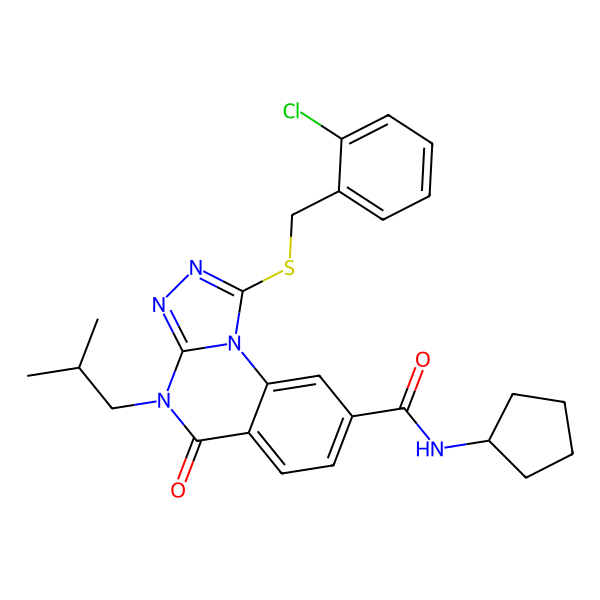

In [31]:

mol = df_small['mol'][42]
AllChem.Compute2DCoords(mol)
# draw the molecule
Draw.MolToImage(mol, size=(600, 600))

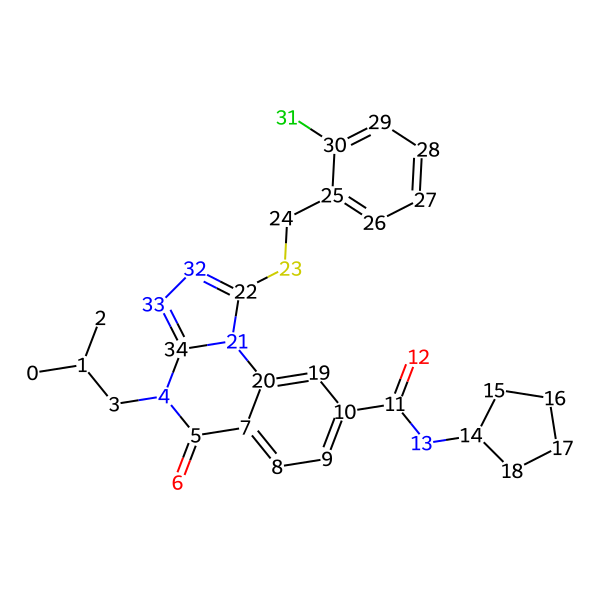

In [32]:

# Function to draw a molecule with atom numbering
def draw_molecule_with_atom_index(mol):
    d2d = rdMolDraw2D.MolDraw2DCairo(600, 600) # or MolDraw2DSVG to get SVG output
    opts = d2d.drawOptions()
    for i in range(mol.GetNumAtoms()):
        opts.atomLabels[i] = str(i)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

# Assuming df_small['mol'][42] is an RDKit molecule
mol = df_small['mol'][42]
AllChem.Compute2DCoords(mol)

# Draw the molecule with atom numbering
img = draw_molecule_with_atom_index(mol)  # This returns binary data for the image
# To display the image in a Jupyter notebook, you can do the following:
IPython.display.Image(data=img)



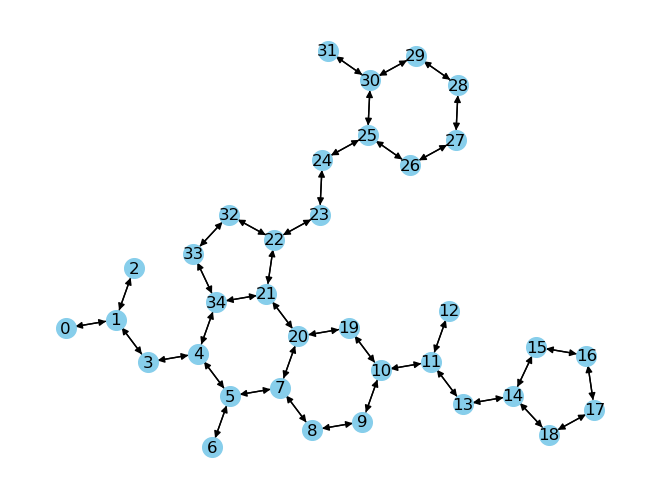

In [33]:
def visualize_graph_with_mol_layout(G, mol):
    pos = {atom_idx: (atom.GetOwningMol().GetConformer().GetAtomPosition(atom_idx).x,
                      atom.GetOwningMol().GetConformer().GetAtomPosition(atom_idx).y)
           for atom_idx, atom in enumerate(mol.GetAtoms())}
    
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='black', arrows=True)
    plt.show()

def mol_to_nx(mol):
    G = nx.DiGraph()  # Initialize a directed graph to allow for bidirectional edges
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        # Add edges in both directions
        G.add_edge(a1, a2)
        G.add_edge(a2, a1)
    return G

# Convert the RDKit molecule to a NetworkX graph
G = mol_to_nx(mol)

# Now visualize the NetworkX graph with the layout based on the molecule
visualize_graph_with_mol_layout(G, mol)

# Create train and test set

In [34]:
# First split into training and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    loaded_graphs_orig, 
    reconstructed_df['rna'], 
    test_size=0.2, 
    random_state=42
)

# Further split the training set into training and validation sets
train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    train_graphs, 
    train_labels, 
    test_size=0.2,  # 20% of the original training set for validation
    random_state=42
)

# merge train and val,  labels are Series
train_graphs_all = train_graphs + val_graphs
train_labels_all = pd.concat([train_labels, val_labels])

there was a problem with few isolated nodes in few graphs so I added loops to each node to have information at least about themselfs

In [35]:
# for i, g in enumerate(train_graphs):
#     if (g.in_degrees() == 0).any():
#         print(f"Graph {i} has isolated nodes")

# # if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
# print('No isolated nodes')

# for i, g in enumerate(test_graphs):
#     if (g.in_degrees() == 0).any():
#         print(f"Graph {i} has isolated nodes")

# # if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
# print('No isolated nodes')

# Graph Attention Networks (GAT)

In [55]:


class GATClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, num_heads=1):
        super(GATClassifier, self).__init__()
        self.conv1 = dgl.nn.GATConv(in_feats, hidden_size, num_heads=num_heads, allow_zero_in_degree=True)
        # Assuming hidden_size * num_heads matches the expected size for the linear layer
        self.fc = nn.Linear(hidden_size * num_heads, 1)  # Adjust the output dimension if needed

    def forward(self, g, features, get_attention=False):
        # Apply GAT convolution
        if get_attention:
            # When get_attention is True, capture both output features and attention weights
            gat_output, attn_weights = self.conv1(g, features, get_attention=True)
        else:
            # When get_attention is False, only capture the output features
            gat_output = self.conv1(g, features, get_attention=False)

        # Mean over heads
        x = F.elu(gat_output.mean(1))  # Adjusted for mean aggregation over heads

        # Update node features
        g.ndata['h'] = x

        # Aggregate node features across the graph
        x = dgl.mean_nodes(g, 'h')

        if get_attention:
            # Return both predictions and attention weights when get_attention is True
            return torch.sigmoid(self.fc(x)), attn_weights
        else:
            # Only return predictions when get_attention is False
            return torch.sigmoid(self.fc(x))


In [46]:
def objective(trial):
    # Define hyperparameter search space
    num_heads = trial.suggest_categorical('num_heads', [1, 2, 4, 8])
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)  # Updated for deprecation warning
    
    in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size

    
    # Initialize the model with suggested hyperparameters
    model = GATClassifier(in_feats, hidden_size=hidden_size, num_heads=num_heads).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping and training loop
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    for epoch in range(100):  # Set a maximum number of epochs
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, _, _, _ = validate(model, val_loader, criterion, device)
        if early_stopping(val_loss, epoch):
            break
    
    return val_loss


In [47]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        
        # batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)



In [48]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False
        self.stopped_epoch = 0  # Attribute to store the epoch number

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch  # Store the epoch number


In [49]:
class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        
        # Reset index if labels is a pandas DataFrame/Series to ensure continuous indexing
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels

    def __len__(self):
        # The lengths of graphs and labels should be the same
        assert len(self.graphs) == len(self.labels), "Graphs and labels must have the same length"
        return len(self.graphs)

    def __getitem__(self, idx):
        try:
            graph = self.graphs[idx]
            label = self.labels[idx]
            return graph, label
        except IndexError:
            print(f"IndexError: Index {idx} out of range for dataset of size {len(self)}")
            raise
        
        

In [50]:
def collate_graphs(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return batched_graph, labels



In [51]:
batch_size = 1024
num_workers = 10

# Assuming train_labels and test_labels are originally 1D tensors or lists
# Create the datasets with updated labels
# Create the DataLoader with multiple workers

if isinstance(train_labels, torch.Tensor):
    train_labels = train_labels.tolist()
train_dataset = GraphDataset(train_graphs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(test_labels, torch.Tensor):
    test_labels = test_labels.tolist()
test_dataset = GraphDataset(test_graphs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(val_labels, torch.Tensor):
    val_labels = val_labels.tolist()
val_dataset = GraphDataset(val_graphs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(train_labels_all, torch.Tensor):
    train_labels_all = train_labels_all.tolist()
train_dataset_all = GraphDataset(train_graphs_all, train_labels_all)
train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)



## Instance of the the GAT Model

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Specify the number of trials

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


## Train the GAT model

In [ ]:
best_params = study.best_trial.params
model = GATClassifier(
    in_feats, 
    hidden_size=best_params['hidden_size'], 
    num_heads=best_params['num_heads']
).to(device)

# Reinitialize the optimizer with the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Train your model with the best hyperparameters (implement the training loop here)


In [ ]:
num_epochs = 500
early_stopping = EarlyStopping(patience=25, min_delta=0.002)

# Initialize lists to store loss values
gat_train_loss_list = []
gat_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    gat_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    gat_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



In [ ]:
# Ensure that the length of gat_train_loss_list and gat_val_loss_list is equal to the number of epochs processed
assert len(gat_train_loss_list) == len(gat_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gat_train_loss_list, label='Training Loss')
plt.plot(gat_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [ ]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

## Reset weights before training again with all data


In [ ]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

In [ ]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [ ]:
# if there is not a folder named 'model' create one
if not os.path.exists('model_experiment'):
    os.mkdir('model_experiment')

# save the model
torch.save(model.state_dict(), 'model_experiment/gat_model_experiment.pth')

In [ ]:
# load the model
model = GATClassifier(in_feats, hidden_size=148, num_heads=4).to(device)
model.load_state_dict(torch.load('model_experiment/gat_model_experiment.pth'))

## Test the model

## Predict probabilities

In [ ]:
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

confidence_percentages = [prob * 100 for prob in y_pred_proba]

y_pred_proba = np.array(y_pred_proba)

## Results

In [ ]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

In [ ]:
# Accuracy: 0.7387478849407784
# Precision: 0.7532486494378742
# Recall: 0.7039159503342884
# F1: 0.727747213993511
# AUC: 0.8162738424254579


In [ ]:
def visualize_molecule_with_attention(mol, attn_weights, threshold=0.1):
    # Convert attention weights to a format suitable for visualization
    # Assume attn_weights is a tensor of shape (num_edges, 1) with attention scores
    attn_weights = attn_weights.squeeze().numpy()
    
    # Identify edges with attention weights above the threshold
    high_attention_edges = [i for i, weight in enumerate(attn_weights) if weight > threshold]
    
    # Map edges in the graph back to bonds in the molecule
    bonds_to_highlight = [mol.GetBondWithIdx(i).GetIdx() for i in high_attention_edges]
    
    # Visualize the molecule with highlighted bonds
    Draw.MolToImage(mol, highlightBonds=bonds_to_highlight)


In [ ]:
# Visualize the molecule with attention
visualize_molecule_with_attention(mol, attn_weights, threshold=0.3)



In [ ]:
# save all visualized molecules with attention and create a folder for them
if not os.path.exists('visualized_molecules'):
    os.mkdir('visualized_molecules')
    
for i, (mol, attn_weights) in enumerate(zip(mols, attn_weights_list)):
    img = visualize_molecule_with_attention(mol, attn_weights, threshold=0.3)
    img.save(f'visualized_molecules/molecule_{i}.png')
    
    


In [ ]:
def extract_high_attention_fragments(mol, attn_weights, threshold=0.1):
    # Similar to visualization, but now store the fragments as SMILES or another format
    submols = []
    for i, weight in enumerate(attn_weights.squeeze().numpy()):
        if weight > threshold:
            # Extract subgraph or fragment; this step depends on how you define a 'fragment'
            # You might need RDKit's substructure search or other techniques to define fragments
            submol = Chem.PathToSubmol(mol, [i])  # Simplified; actual implementation may vary
            submols.append(Chem.MolToSmiles(submol))
    return submols


In [ ]:
# Extract high-attention fragments
high_attention_fragments = extract_high_attention_fragments(mol, attn_weights, threshold=0.3)

# save as json
with open('high_attention_fragments.json', 'w') as f:
    json.dump(high_attention_fragments, f)

## Confusion matrix

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gat_experiment.png', dpi=300)
plt.show()



## Classification report

In [ ]:
# classification report
print(classification_report(y_true, y_pred))


## ROC AUC

In [ ]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gat_experiment.png', dpi=300)
plt.show()


In [ ]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gat_experiment.png', dpi=300)
plt.show()


In [ ]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [ ]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gat_experiment'):
    os.mkdir('top_molecules_gat_experiment')
    

In [ ]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


In [ ]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    plt.show()


In [ ]:
# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='talk', rc={'figure.figsize': (11.5, 7)})

plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_talk_experiment.png', dpi=300)
plt.show()


# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='paper', rc={'figure.figsize': (10, 4)})


plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_paper_experiment.png', dpi=300)
plt.show()


